<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

# TFM - Sistema de alerta ante la presencia de Didymosphenia Geminata en agua dulce con técnicas de inteligencia artificial

Presentado por: Aracena Vallejos, Estefania – Medina Jiménez, Lenin  
Directora: Prados Privado, María

## K-Means, Gaussian Mixture Model (GMM) y Fuzzy C-Means

El objetivo es implementar un modelo de predicción del crecimiento de Didymo en los sistemas hídricos de Chile, empleando  técnicas aprendizaje no supervisado de clustering utilizando la información proporcionada por el Instituto de Fomento Pesquero de Puerto Montt. Se emplearán tres métodos de clustering: K-Means, Gaussian Mixtures y Fuzzy C-Means

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

#Para Pre-procesar 
from sklearn import preprocessing
from sklearn.decomposition import PCA
from yellowbrick.features import PCA as PCAVisualizer

#Para Clustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from fcmeans import FCM as fcm
#from skfda.ml.clustering import FuzzyCMeans

In [2]:
data = pd.read_csv("data.csv", delimiter=';')
data

,Unnamed: 0,T°,categoria,pH,Ce,TDS,OD,%Sat. O,Ca,PO4,...,Crec_algal_Inicial,Crec_algal_Mediana,Crec_algal_Alta,Crec_algal_Muy Alta,%Cob_algal_ausente,%Cob_algal_Pequenas colonias,%Cob_algal_Mediana,%Cob_algal_Alta,%Cob_algal_Muy Alta,Didymo
0,0,14.8,%Cob_algal_Alta,8.2,80.0,40.0,11.8,118.4,7.9,1.000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00
1,1,15.6,%Cob_algal_Alta,6.7,73.0,36.0,12.2,124.2,9.2,1.000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00
2,2,11.1,%Cob_algal_Alta,7.1,152.0,76.0,10.0,101.5,5.5,1.000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00
3,3,15.2,%Cob_algal_Alta,7.8,82.0,13.8,11.8,111.8,4.2,1.000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00
4,4,13.9,%Cob_algal_Muy Alta,7.4,31.0,15.0,10.4,102.3,4.5,1.000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600,1600,6.0,%Cob_algal_Mediana,7.5,44.0,22.0,18.8,117.3,8.3,0.151,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.51
1601,1601,13.5,%Cob_algal_Muy Alta,7.5,49.0,25.0,11.4,109.7,6.0,0.001,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00
1602,1602,11.7,%Cob_algal_Alta,7.4,74.0,37.0,11.3,105.9,5.3,0.001,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00
1603,1603,7.0,%Cob_algal_Alta,7.4,39.0,19.0,13.3,118.4,8.3,0.151,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.51


In [3]:
data = data.drop(columns=['Unnamed: 0', 'categoria', 'prof_m', 'vel_0.2_m', 'vel_0.6_m', 'vel_0.8_m', 'Crec_algal_Ausente',
       'Crec_algal_Inicial', 'Crec_algal_Mediana', 'Crec_algal_Alta', 'Crec_algal_Muy Alta', '%Cob_algal_ausente',
       '%Cob_algal_Pequenas colonias', '%Cob_algal_Mediana', '%Cob_algal_Alta', '%Cob_algal_Muy Alta', ])

In [4]:
columnas_pca = data.columns
columnas_pca

Index(['T°', 'pH', 'Ce', 'TDS', 'OD', '%Sat. O', 'Ca', 'PO4', 'P T', 'Fe',
       'NO3', 'NO2', 'NT', 'NKT', 'Si T', 'Turbidez', 'Didymo'],
      dtype='object')

In [5]:
data_scale = preprocessing.scale(data)
df = pd.DataFrame(data_scale, columns=columnas_pca).round(2)
df

,T°,pH,Ce,TDS,OD,%Sat. O,Ca,PO4,P T,Fe,NO3,NO2,NT,NKT,Si T,Turbidez,Didymo
0,0.99,1.27,-0.03,-0.03,1.14,1.48,0.02,2.70,2.42,-0.60,-0.04,2.44,1.98,2.06,-1.48,-0.09,-0.33
1,1.20,-1.18,-0.04,-0.04,1.48,2.05,0.21,2.70,2.88,-0.60,-0.04,2.44,3.32,3.42,1.34,-0.10,-0.33
2,-0.01,-0.53,0.10,0.11,-0.41,-0.16,-0.34,2.70,0.57,-0.60,-0.04,2.44,1.19,1.26,1.51,-0.10,-0.33
3,1.10,0.61,-0.03,-0.13,1.14,0.84,-0.53,2.70,4.26,-0.60,-0.04,2.44,1.27,1.34,0.43,-0.09,-0.33
4,0.75,-0.04,-0.12,-0.12,-0.06,-0.09,-0.48,2.70,0.57,-0.60,-0.04,2.44,1.27,1.34,-0.38,-0.09,-0.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600,-1.38,0.12,-0.10,-0.10,7.15,1.38,0.08,0.05,-0.19,-0.51,-0.00,0.02,-0.09,-0.08,0.50,-0.09,-0.30
1601,0.64,0.12,-0.09,-0.08,0.79,0.63,-0.26,-0.42,-0.34,-0.63,-0.01,-0.42,-0.25,-0.25,-0.20,-0.09,-0.33
1602,0.16,-0.04,-0.04,-0.04,0.71,0.26,-0.36,-0.42,-0.34,-0.62,-0.03,-0.45,-0.25,-0.24,0.71,-0.09,-0.33
1603,-1.11,-0.04,-0.11,-0.11,2.43,1.48,0.08,0.05,-0.19,-0.51,-0.00,0.02,-0.09,-0.08,0.50,-0.09,-0.30


In [6]:
df_pca = df

# K-Means

In [7]:
df_pca1 = df_pca.copy()

  File "c:\Users\earac\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


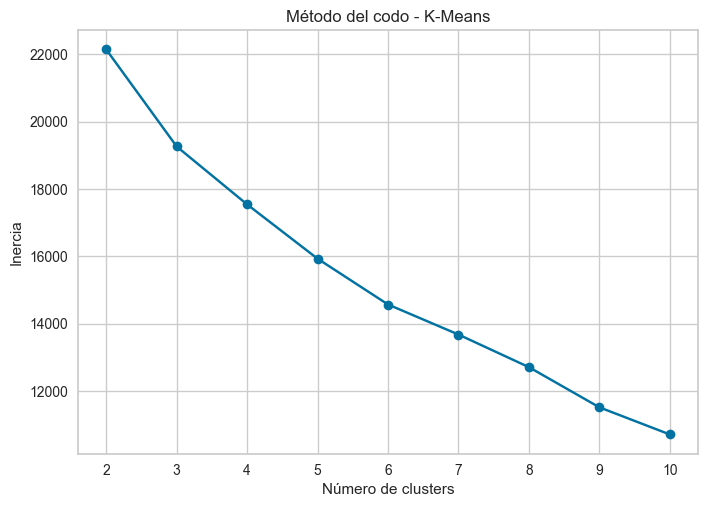

In [8]:
warnings.filterwarnings("ignore")
inercia = []
for i in range(2,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 12)
    kmeans.fit(df_pca1)
    inercia.append(kmeans.inertia_)
    
plt.plot(range(2, 11), inercia, marker='o')
plt.title('Método del codo - K-Means')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.savefig('kmeans-codo.jpg')
plt.show()

In [9]:
k = KneeLocator(range(2, 11), inercia, curve='convex', direction='decreasing')    # Use the KneeLocator to find the elbow point in the inertia plot
print("Número óptimo de clusters:", k.elbow) 

Número óptimo de clusters: 5


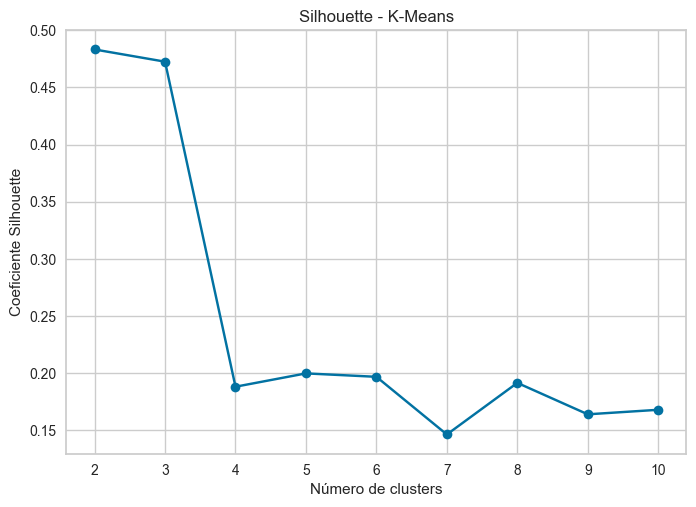

In [10]:
silhouette_coefficients = []                          
for i in range(2, 11):                               
    kmeans = KMeans(n_clusters=i , init = 'k-means++', random_state = 12)      
    kmeans.fit(df_pca1)                                
    score = silhouette_score(df_pca1, kmeans.labels_) 
    silhouette_coefficients.append(score)  

plt.plot(range(2, 11), silhouette_coefficients, marker='o')
plt.title('Silhouette - K-Means')
plt.xlabel('Número de clusters')
plt.ylabel('Coeficiente Silhouette')
plt.savefig('kmeans-silueta.jpg')
plt.show()

In [11]:
warnings.filterwarnings('ignore')
kmeans = KMeans(n_clusters = 5, init = "k-means++", max_iter=1000, tol=0.00001, random_state = 42, 
                 algorithm='elkan').fit(df_pca1)

df_pca1['cluster'] = kmeans.labels_

centers = pd.DataFrame(kmeans.cluster_centers_, columns= [columnas_pca])

#centers['freq']=df_pca['cluster'].value_counts()
#centers['freq_r']=df_pca['cluster'].value_counts(normalize=True)
#centers

In [12]:
df_pca1['cluster'].value_counts()

cluster
0    980
2    426
1    194
3      3
4      2
Name: count, dtype: int64

In [13]:
df_pca1['S_S'] = silhouette_samples(df_pca1,df_pca1['cluster'])
silhouette_kmeans = silhouette_score(df_pca1,df_pca1['cluster'])
print(silhouette_kmeans)

0.27881968441007826


# Gaussian Mixtures

In [14]:
df_pca2 = df_pca.copy()

In [15]:
# Define the parameter grid
param_grid = {
    'n_components': range(2, 11),                              
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],  
    'init_params': ['kmeans', 'random']                        
}

# Create the GMM model
gmm = GaussianMixture(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(gmm, param_grid, cv=5, n_jobs=-1)
grid_search.fit(df_pca2) 

# Get the best model and its parameters
best_gmm = grid_search.best_estimator_
best_params = grid_search.best_params_

print('Mejores parámetros: ', best_params)

Mejores parámetros:  {'covariance_type': 'diag', 'init_params': 'random', 'n_components': 8}


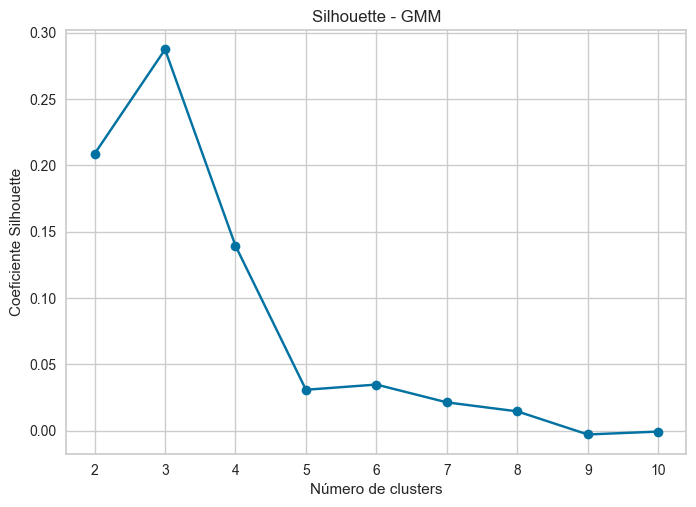

In [16]:
silhouette_coefficients = []
for n in range(2,11) : 
    gmm = GaussianMixture(n_components=n, random_state=42, covariance_type='diag', init_params='random')
    gmm.fit(df_pca2)
    score = silhouette_score(df_pca2, gmm.predict(df_pca2))
    silhouette_coefficients.append(score)
    
plt.plot(range(2, 11), silhouette_coefficients, marker='o')
plt.title('Silhouette - GMM')
plt.xlabel('Número de clusters')
plt.ylabel('Coeficiente Silhouette')
plt.savefig('gm-silueta.jpg')
plt.show()

In [17]:
gmm = GaussianMixture(n_components=5, random_state=42, covariance_type='diag', init_params='random')
gmm.fit(df_pca2)
#print('means: ', gmm.means_)                         # Cluster means
#print('covariances: ', gmm.covariances_)             # Covariance matrices
#print('weights: ', gmm.weights_)                     # Mixing coefficients
gmm_prediccion = gmm.predict(df_pca2)

df_pca2['cluster'] = gmm.predict(df_pca2)
df_pca2

,T°,pH,Ce,TDS,OD,%Sat. O,Ca,PO4,P T,Fe,NO3,NO2,NT,NKT,Si T,Turbidez,Didymo,cluster
0,0.99,1.27,-0.03,-0.03,1.14,1.48,0.02,2.70,2.42,-0.60,-0.04,2.44,1.98,2.06,-1.48,-0.09,-0.33,1
1,1.20,-1.18,-0.04,-0.04,1.48,2.05,0.21,2.70,2.88,-0.60,-0.04,2.44,3.32,3.42,1.34,-0.10,-0.33,1
2,-0.01,-0.53,0.10,0.11,-0.41,-0.16,-0.34,2.70,0.57,-0.60,-0.04,2.44,1.19,1.26,1.51,-0.10,-0.33,1
3,1.10,0.61,-0.03,-0.13,1.14,0.84,-0.53,2.70,4.26,-0.60,-0.04,2.44,1.27,1.34,0.43,-0.09,-0.33,1
4,0.75,-0.04,-0.12,-0.12,-0.06,-0.09,-0.48,2.70,0.57,-0.60,-0.04,2.44,1.27,1.34,-0.38,-0.09,-0.33,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600,-1.38,0.12,-0.10,-0.10,7.15,1.38,0.08,0.05,-0.19,-0.51,-0.00,0.02,-0.09,-0.08,0.50,-0.09,-0.30,0
1601,0.64,0.12,-0.09,-0.08,0.79,0.63,-0.26,-0.42,-0.34,-0.63,-0.01,-0.42,-0.25,-0.25,-0.20,-0.09,-0.33,3
1602,0.16,-0.04,-0.04,-0.04,0.71,0.26,-0.36,-0.42,-0.34,-0.62,-0.03,-0.45,-0.25,-0.24,0.71,-0.09,-0.33,3
1603,-1.11,-0.04,-0.11,-0.11,2.43,1.48,0.08,0.05,-0.19,-0.51,-0.00,0.02,-0.09,-0.08,0.50,-0.09,-0.30,0


In [18]:
df_pca2['S_S'] = silhouette_samples(df_pca2,gmm_prediccion)
silhouette_score_gmm = silhouette_score(df_pca2,gmm_prediccion)
print(silhouette_score_gmm)

0.1777656353648791


In [19]:
df_pca2['cluster'].value_counts()

cluster
3    760
2    347
0    264
1    180
4     54
Name: count, dtype: int64

# Fuzzy C-Means

In [20]:
df_pca3 = df_pca.copy()

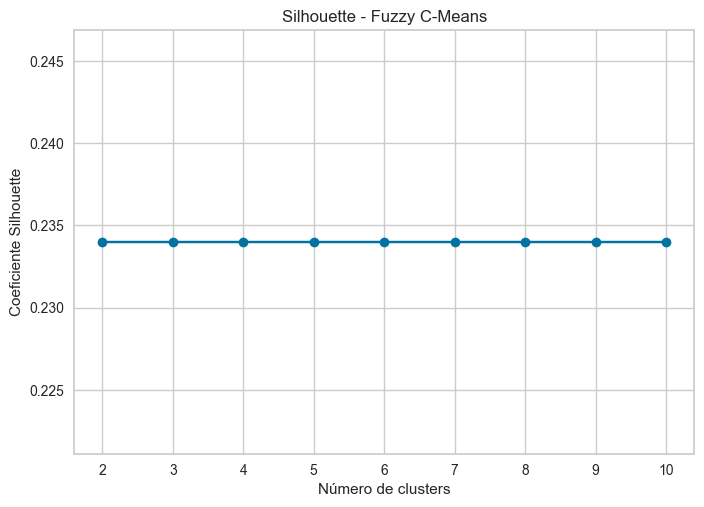

In [21]:
silhouette_coefficients = []                          
for i in range(2, 11):                               
    fuzzy = fcm(n_clusters=i)      
    fuzzy.fit(df_pca3.values)                                
    score = silhouette_score(df_pca3, fuzzy.predict(df_pca3.values)) 
    silhouette_coefficients.append(score)  

plt.plot(range(2, 11), silhouette_coefficients, marker='o')
plt.title('Silhouette - Fuzzy C-Means')
plt.xlabel('Número de clusters')
plt.ylabel('Coeficiente Silhouette')
plt.savefig('fcm-silueta.jpg')
plt.show()

In [22]:
#warnings.filterwarnings("ignore")
#inercia = []
#for i in range(2,11):
#    fuzzy1 = fcm(n_clusters = 3)
#    fuzzy1.fit(df_pca3.values)
#    inercia.append(fuzzy1.inertia_)
    
#plt.plot(range(2, 11), inercia, marker='o')
#plt.title('The Elbow Method')
#plt.xlabel('Number of clusters')
#plt.ylabel('Inercia')
#plt.show()

In [23]:
fuzzy1 = fcm(n_clusters = 5)
fuzzy1.fit(df_pca3.values)
fcm_centers = fuzzy1.centers
fcm_labels  = fuzzy1.u.argmax(axis=1)
fuzzy_pred = fuzzy1.predict(df_pca3.values)

In [24]:
df_pca3['cluster'] = fuzzy_pred
df_pca3

,T°,pH,Ce,TDS,OD,%Sat. O,Ca,PO4,P T,Fe,NO3,NO2,NT,NKT,Si T,Turbidez,Didymo,cluster
0,0.99,1.27,-0.03,-0.03,1.14,1.48,0.02,2.70,2.42,-0.60,-0.04,2.44,1.98,2.06,-1.48,-0.09,-0.33,4
1,1.20,-1.18,-0.04,-0.04,1.48,2.05,0.21,2.70,2.88,-0.60,-0.04,2.44,3.32,3.42,1.34,-0.10,-0.33,4
2,-0.01,-0.53,0.10,0.11,-0.41,-0.16,-0.34,2.70,0.57,-0.60,-0.04,2.44,1.19,1.26,1.51,-0.10,-0.33,4
3,1.10,0.61,-0.03,-0.13,1.14,0.84,-0.53,2.70,4.26,-0.60,-0.04,2.44,1.27,1.34,0.43,-0.09,-0.33,4
4,0.75,-0.04,-0.12,-0.12,-0.06,-0.09,-0.48,2.70,0.57,-0.60,-0.04,2.44,1.27,1.34,-0.38,-0.09,-0.33,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600,-1.38,0.12,-0.10,-0.10,7.15,1.38,0.08,0.05,-0.19,-0.51,-0.00,0.02,-0.09,-0.08,0.50,-0.09,-0.30,4
1601,0.64,0.12,-0.09,-0.08,0.79,0.63,-0.26,-0.42,-0.34,-0.63,-0.01,-0.42,-0.25,-0.25,-0.20,-0.09,-0.33,4
1602,0.16,-0.04,-0.04,-0.04,0.71,0.26,-0.36,-0.42,-0.34,-0.62,-0.03,-0.45,-0.25,-0.24,0.71,-0.09,-0.33,3
1603,-1.11,-0.04,-0.11,-0.11,2.43,1.48,0.08,0.05,-0.19,-0.51,-0.00,0.02,-0.09,-0.08,0.50,-0.09,-0.30,4


In [25]:
df_pca3['S_S'] = silhouette_samples(df_pca3,fuzzy_pred)
silhouette_score_fcm = silhouette_score(df_pca3,fuzzy_pred)
print(silhouette_score_fcm)

0.2530460520167997


In [26]:
df_pca3['cluster'].value_counts()

cluster
3    1048
4     557
Name: count, dtype: int64

In [27]:
info1 = pd.DataFrame({'Model':['KMeans', 'Gaussian Mixture Model (GMM)', 'Fuzzy C-Means'],
                        'silhouette_score':[silhouette_kmeans, silhouette_score_gmm, silhouette_score_fcm ]})
info1.style.highlight_max(color="green")

,Model,silhouette_score
0,KMeans,0.278820
1,Gaussian Mixture Model (GMM),0.177766
2,Fuzzy C-Means,0.253046


In [28]:
#df_pca2.to_csv('cluster.csv', sep=';')

### Visualización clusters

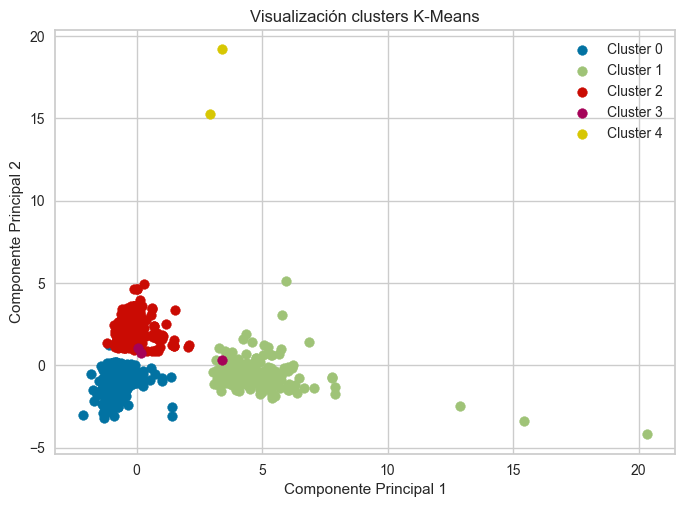

In [29]:
# Realizar una proyección en dos dimensiones utilizando PCA
pca1 = PCA(n_components=2)
data_1d = pca1.fit_transform(df_pca1)

# Obtener los valores de las variables proyectadas en dos dimensiones
x = data_1d[:, 0]
y = data_1d[:, 1]

# Obtener los valores de los clusters
cluster_labels1 = df_pca1['cluster'].squeeze()

# Crear un gráfico de dispersión para cada cluster
for label in set(cluster_labels1):
    cluster_indices = cluster_labels1 == label
    plt.scatter(x[cluster_indices], y[cluster_indices], label=f'Cluster {label}')

# Etiquetas de los ejes
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.title('Visualización clusters K-Means')
plt.savefig('kmeans-visual.jpg')
plt.show()

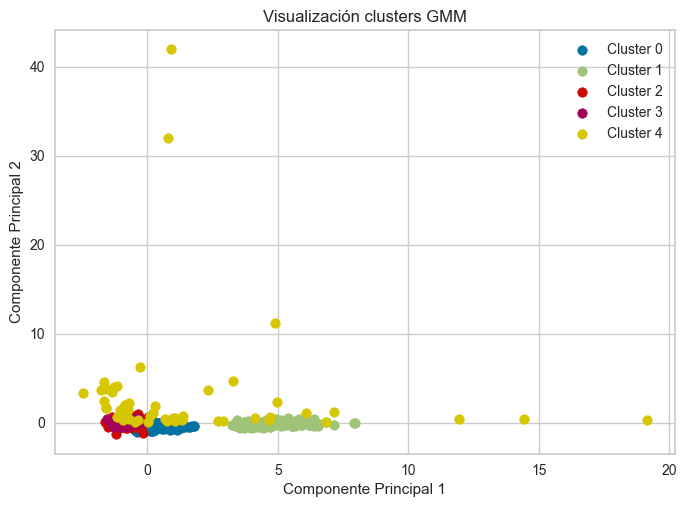

In [30]:
# Realizar una proyección en dos dimensiones utilizando PCA
pca2 = PCA(n_components=2)
data_2d = pca2.fit_transform(df_pca2)

# Obtener los valores de las variables proyectadas en dos dimensiones
x = data_2d[:, 0]
y = data_2d[:, 1]

# Obtener los valores de los clusters
cluster_labels2 = df_pca2['cluster'].squeeze()

# Crear un gráfico de dispersión para cada cluster
for label in set(cluster_labels2):
    cluster_indices = cluster_labels2 == label
    plt.scatter(x[cluster_indices], y[cluster_indices], label=f'Cluster {label}')

# Etiquetas de los ejes
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Visualización clusters GMM')
plt.legend()
plt.savefig('gm-visual.jpg')
plt.show()

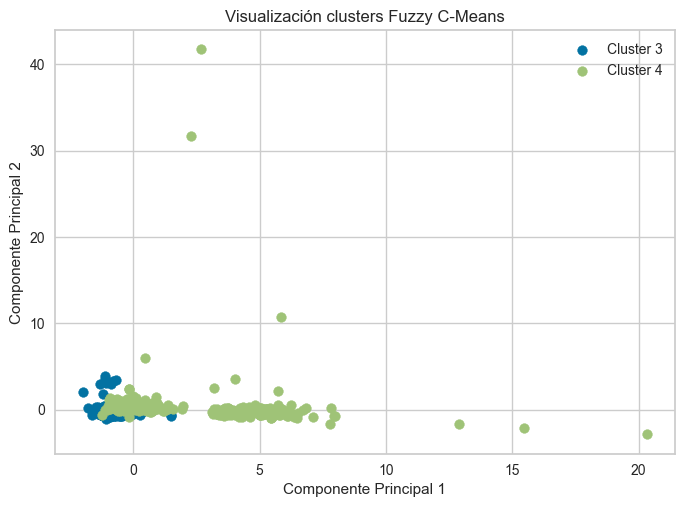

In [31]:
# Realizar una proyección en dos dimensiones utilizando PCA
pca3 = PCA(n_components=2)
data_3d = pca3.fit_transform(df_pca3)

# Obtener los valores de las variables proyectadas en dos dimensiones
x = data_3d[:, 0]
y = data_3d[:, 1]

# Obtener los valores de los clusters
cluster_labels3 = df_pca3['cluster'].squeeze()

# Crear un gráfico de dispersión para cada cluster
for label in set(cluster_labels3):
    cluster_indices = cluster_labels3 == label
    plt.scatter(x[cluster_indices], y[cluster_indices], label=f'Cluster {label}')

# Etiquetas de los ejes
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Visualización clusters Fuzzy C-Means')
plt.legend()
plt.savefig('fcm-visual.jpg')
plt.show()